<a href="https://colab.research.google.com/github/Akobabs/COMPUTER-AIDED-VISION-FOR-PLANT-DISEASE-DETECTION/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
GPU Name: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile
import os

# Path to the zipped dataset in Google Drive
zip_path = '/content/drive/My Drive/PlantDiseaseData.zip'
extract_path = '/content/PlantVillage'

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extracted files
print("Extracted files:", os.listdir(extract_path))

Extracted files: ['PlantVillage', 'plantvillage']


In [8]:
!rm -r PlantVillage/plantvillage


In [9]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define paths
data_dir = '/content/PlantVillage/PlantVillage'
output_dir = '/content/PlantVillage'
os.makedirs(output_dir, exist_ok=True)
metadata_csv = os.path.join(output_dir, 'metadata.csv')

# Collect image paths and labels
image_paths, labels = [], []
image_extensions = (".jpg", ".jpeg", ".png", ".gif", ".bmp")

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"Processing folder: {class_name}")
        img_count = 0
        for img in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img)
            if os.path.isfile(img_path) and img.lower().endswith(image_extensions):
                image_paths.append(img_path)
                labels.append(class_name)
                img_count += 1
        print(f"Found {img_count} images in {class_name}")

# Save to CSV
df = pd.DataFrame({"image_path": image_paths, "label": labels})
df.to_csv(metadata_csv, index=False)
print(f"✅ metadata.csv created with {len(df)} images across {df['label'].nunique()} classes.")

# Split into train/val/test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df["label"], random_state=42)

train_df.to_csv(os.path.join(output_dir, "train.csv"), index=False)
val_df.to_csv(os.path.join(output_dir, "val.csv"), index=False)
test_df.to_csv(os.path.join(output_dir, "test.csv"), index=False)

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")










Processing folder: Tomato_Septoria_leaf_spot
Found 1771 images in Tomato_Septoria_leaf_spot
Processing folder: Tomato__Tomato_YellowLeaf__Curl_Virus
Found 3208 images in Tomato__Tomato_YellowLeaf__Curl_Virus
Processing folder: Pepper__bell___healthy
Found 1478 images in Pepper__bell___healthy
Processing folder: Potato___Early_blight
Found 1000 images in Potato___Early_blight
Processing folder: Tomato__Target_Spot
Found 1404 images in Tomato__Target_Spot
Processing folder: Potato___healthy
Found 152 images in Potato___healthy
Processing folder: Tomato_Early_blight
Found 1000 images in Tomato_Early_blight
Processing folder: Pepper__bell___Bacterial_spot
Found 997 images in Pepper__bell___Bacterial_spot
Processing folder: Tomato_healthy
Found 1591 images in Tomato_healthy
Processing folder: Potato___Late_blight
Found 1000 images in Potato___Late_blight
Processing folder: Tomato_Bacterial_spot
Found 2127 images in Tomato_Bacterial_spot
Processing folder: Tomato__Tomato_mosaic_virus
Found 3

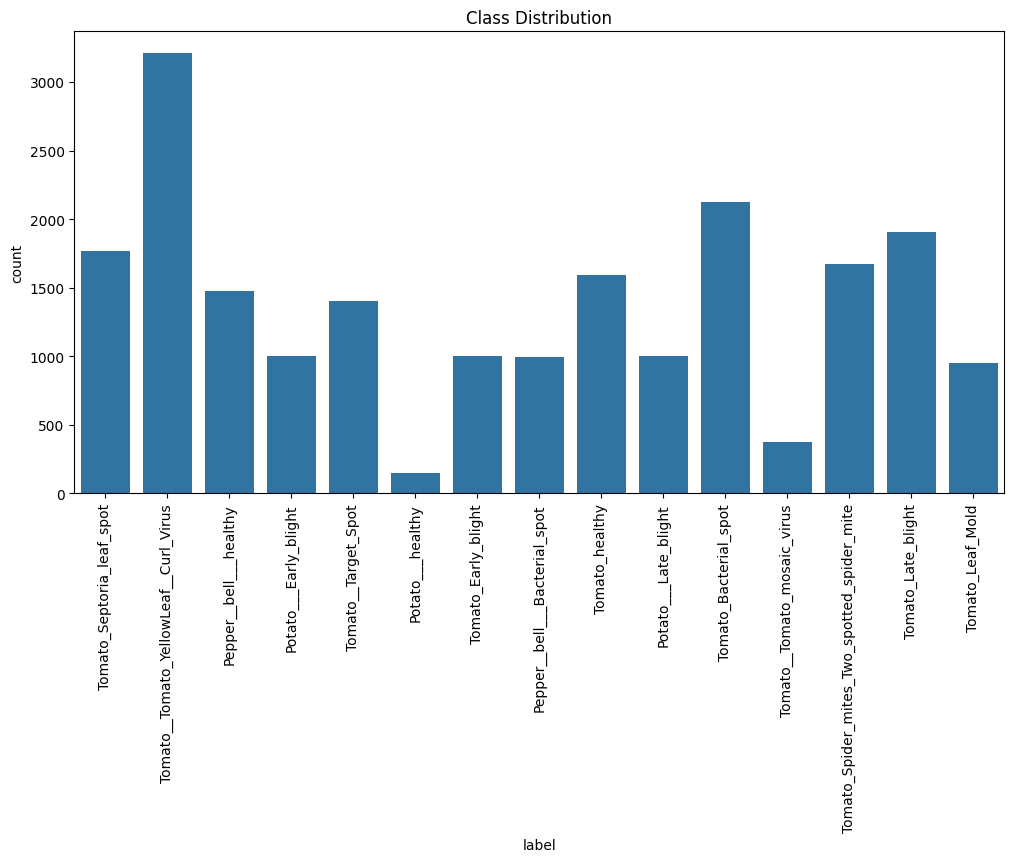

Image Quality Check (Sample):
reason
Good      91
Blurry     9
Name: count, dtype: int64
Removed 943 bad images. Cleaned dataset size: 19695
Balanced dataset size: 24051


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Load metadata
metadata_csv = '/content/PlantVillage/metadata.csv'  # Update path if using Drive
df = pd.read_csv(metadata_csv)

# Class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x="label", data=df)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.show()

# Image quality check (simplified)
def check_image_quality(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return False, "Corrupted"
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        if laplacian_var < 100:
            return False, "Blurry"
        brightness = np.mean(img)
        if brightness < 30 or brightness > 225:
            return False, "Too dark/bright"
        return True, "Good"
    except:
        return False, "Error"

# Sample quality check
sample_df = df.sample(n=min(100, len(df)), random_state=42)
quality_results = [check_image_quality(img_path) for img_path in sample_df["image_path"]]
quality_df = pd.DataFrame(quality_results, columns=["is_good", "reason"])
print("Image Quality Check (Sample):")
print(quality_df["reason"].value_counts())

# Remove bad images
all_quality_results = [check_image_quality(img_path) for img_path in df["image_path"]]
quality_df_full = pd.DataFrame(all_quality_results, columns=["is_good", "reason"])
bad_images = df[quality_df_full["is_good"] == False]["image_path"]
cleaned_df = df[~df["image_path"].isin(bad_images)]
print(f"Removed {len(bad_images)} bad images. Cleaned dataset size: {len(cleaned_df)}")

# Balance the dataset (oversample minority classes)
class_counts = cleaned_df["label"].value_counts()
median_count = class_counts.median()
balanced_dfs = []
for label in cleaned_df["label"].unique():
    class_df = cleaned_df[cleaned_df["label"] == label]
    if len(class_df) < median_count:
        oversampled_df = class_df.sample(n=int(median_count), replace=True, random_state=42)
        balanced_dfs.append(oversampled_df)
    else:
        balanced_dfs.append(class_df)

balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)
balanced_df.to_csv('/content/PlantVillage/balanced_metadata.csv', index=False)
print(f"Balanced dataset size: {len(balanced_df)}")

# Split the dataset
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df["label"], random_state=42)

train_df.to_csv('/content/PlantVillage/train.csv', index=False)
val_df.to_csv('/content/PlantVillage/val.csv', index=False)
test_df.to_csv('/content/PlantVillage/test.csv', index=False)

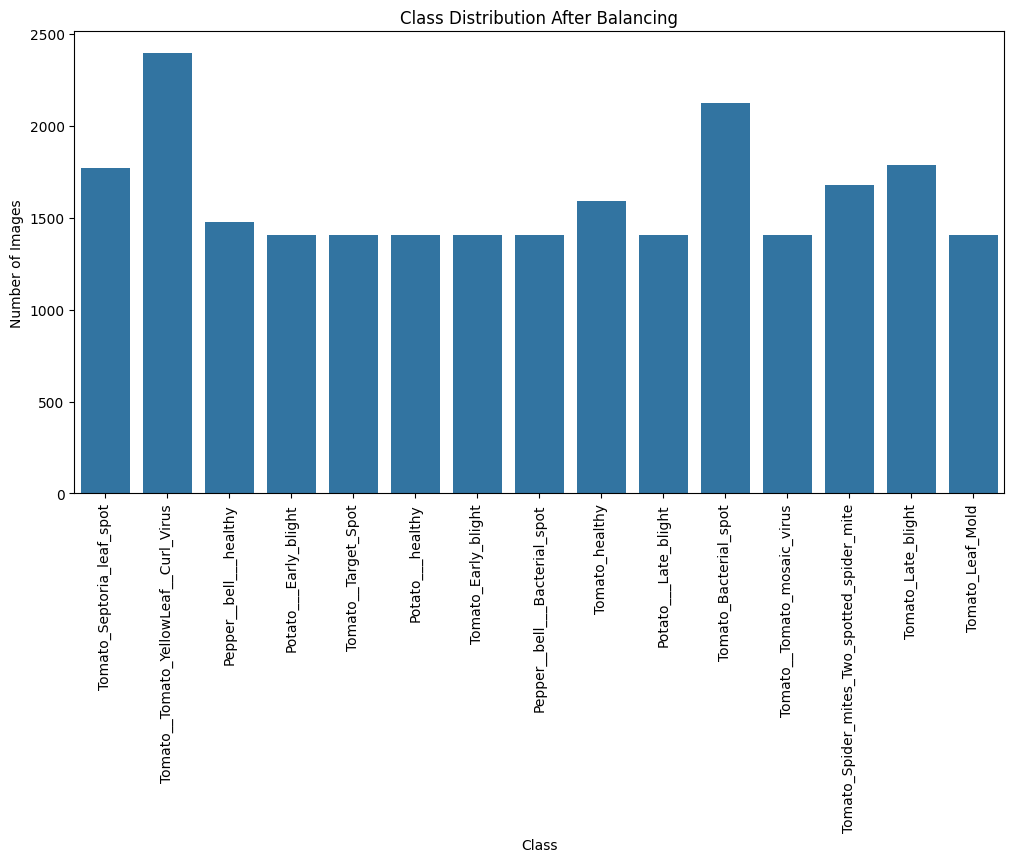

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(x="label", data=balanced_df)
plt.xticks(rotation=90)
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [13]:
# Define paths
train_csv = '/content/PlantVillage/train.csv'
val_csv = '/content/PlantVillage/val.csv'
test_csv = '/content/PlantVillage/test.csv'
model_dir = '/content/models'
os.makedirs(model_dir, exist_ok=True)

In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# Custom Dataset
class PlantDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df["label"].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        label = self.label_map[self.df.iloc[idx]["label"]]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# Load datasets
train_dataset = PlantDataset(train_csv, transform=train_transform)
val_dataset = PlantDataset(val_csv, transform=val_transform)
test_dataset = PlantDataset(test_csv, transform=val_transform)

In [17]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Define the hybrid model
class HybridCNNViT(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNViT, self).__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()
        cnn_out_features = 2048
        self.vit = models.vit_b_16(pretrained=True)
        vit_out_features = self.vit.heads.head.in_features
        self.vit.heads = nn.Identity()
        self.fusion = nn.Linear(cnn_out_features + vit_out_features, 512)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        cnn_features = self.cnn(x)
        vit_features = self.vit(x)
        combined_features = torch.cat((cnn_features, vit_features), dim=1)
        fused = self.fusion(combined_features)
        fused = torch.relu(fused)
        output = self.classifier(fused)
        return output

In [19]:
# Initialize the model
num_classes = len(train_dataset.label_map)
model = HybridCNNViT(num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 50
best_val_loss = float("inf")
patience = 5
patience_counter = 0
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, "plantvillage_hybrid_best.pth"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Evaluate on test set
model.load_state_dict(torch.load(os.path.join(model_dir, "plantvillage_hybrid_best.pth")))
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Epoch 1/50 | Train Loss: 0.2600 | Val Loss: 0.0486 | Val Accuracy: 0.9849
Epoch 2/50 | Train Loss: 0.1021 | Val Loss: 0.0326 | Val Accuracy: 0.9903
Epoch 3/50 | Train Loss: 0.0836 | Val Loss: 0.0482 | Val Accuracy: 0.9845
Epoch 4/50 | Train Loss: 0.0747 | Val Loss: 0.0679 | Val Accuracy: 0.9764
Epoch 5/50 | Train Loss: 0.0667 | Val Loss: 0.0393 | Val Accuracy: 0.9851
Epoch 6/50 | Train Loss: 0.0547 | Val Loss: 0.0805 | Val Accuracy: 0.9721
Epoch 7/50 | Train Loss: 0.0538 | Val Loss: 0.0259 | Val Accuracy: 0.9888
Epoch 8/50 | Train Loss: 0.0459 | Val Loss: 0.0598 | Val Accuracy: 0.9818


KeyboardInterrupt: 

In [21]:
# Evaluate on test set
model.load_state_dict(torch.load(os.path.join(model_dir, "plantvillage_hybrid_best.pth")))
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average="weighted")
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Test Set Evaluation:
Accuracy: 0.9916
Precision: 0.9918
Recall: 0.9916
F1-Score: 0.9916


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
!ls /content/drive

MyDrive  Othercomputers


In [31]:
!mkdir -p "/content/drive/My Drive/PlantDiseaseProject"

In [32]:
# Copy the model to Google Drive
!cp /content/models/plantvillage_hybrid_best.pth "/content/drive/My Drive/PlantDiseaseProject/plantvillage_hybrid_best.pth"